In [9]:
%load_ext autoreload
%autoreload 2
%aimport

Modules to reload:
all-except-skipped

Modules to skip:



In [10]:
%matplotlib inline

In [11]:
import numpy as np
import matplotlib.pyplot as plt 
import warnings
from tqdm import tqdm

In [12]:
from scipy.interpolate import interp1d
from scipy.stats import rankdata
from sklearn import linear_model
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import QuantileTransformer

In [149]:
from scipy import stats

def spearmanr(*args, **kwargs):
    return stats.spearmanr(*args, **kwargs).correlation

## Model implementation

In [14]:
def _value_at_rank(x, ranks):
    """Get value at ranks of multidimensional array."""
    assert x.shape[1] == ranks.shape[1]
    assert ranks.dtype == int
    n, m = ranks.shape
    y = np.zeros((n, m), dtype=float)
    for ii in range(m):
        y[:, ii] = np.take(x[:, ii], ranks[:, ii])
    return y

In [15]:
class MultiCAM_OG:
    def __init__(self, n_features: int, n_targets: int) -> None:
        assert isinstance(n_features, int) and n_features > 0
        self.n_features = n_features
        self.n_targets = n_targets
        self.trained = False 

        # additional metadata that needs to be saved for prediction.
        self.qt_xr = None
        self.qt_yr = None
        self.qt_x = None
        self.qt_y = None
        self.y_train = None
        self.x_train = None

        # setup linear regression model
        self.reg = linear_model.LinearRegression()


    def fit(self, x, y):
        """Fit model using training data"""
        assert np.sum(np.isnan(x)) == np.sum(np.isnan(y)) == 0
        assert x.shape == (y.shape[0], self.n_features)
        assert y.shape == (x.shape[0], self.n_targets)

        # need to save training data to predict from ranks later.
        self.x_train = x.copy()
        self.y_train = y.copy()

        # first get ranks of features and targets.
        xr = rankdata(x, axis=0, method="ordinal")
        yr = rankdata(y, axis=0, method="ordinal")

        # then get a quantile transformer for the ranks to a normal distribution.
        self.qt_xr = QuantileTransformer(n_quantiles=len(xr), output_distribution="normal")
        self.qt_xr = self.qt_xr.fit(xr)
        self.qt_yr = QuantileTransformer(n_quantiles=len(yr), output_distribution="normal")
        self.qt_yr = self.qt_yr.fit(yr)

        x_gauss, y_gauss = self.qt_xr.transform(xr), self.qt_yr.transform(yr)

        # then fit a linear regression model to the transformed data.
        self.reg.fit(x_gauss, y_gauss)
        
        self.trained = True

    def predict(self, x):
        assert len(x.shape) == 2
        assert x.shape[1] == self.n_features
        assert np.sum(np.isnan(x)) == 0
        assert self.trained

        # get ranks of test data.
        xr = rankdata(x, axis=0, method="ordinal")
        xr = (xr - 1) * (len(self.x_train) - 1) / (len(x) - 1) + 1
        
        # transform ranks to be (marginally) gaussian.
        xr_trans = self.qt_xr.transform(xr)

        # predict on transformed ranks.
        yr_trans = self.reg.predict(xr_trans)

        # get quantile transformer of prediction to (marginal) normal.
        qt_pred = QuantileTransformer(n_quantiles=len(yr_trans), output_distribution="normal")
        qt_pred.fit(yr_trans)

        # inverse transform prediction to get ranks of target.
        yr = self.qt_yr.inverse_transform(qt_pred.transform(yr_trans)).astype(int) - 1

        # predictions are points in train data corresponding to ranks predicted
        y_train_sorted = np.sort(self.y_train, axis=0)
        y_pred = _value_at_rank(y_train_sorted, yr)

        return y_pred

In [16]:
class MultiCAM:
    def __init__(self, n_features: int, n_targets: int) -> None:
        assert isinstance(n_features, int) and n_features > 0
        self.n_features = n_features
        self.n_targets = n_targets
        self.trained = False 

        # additional metadata that needs to be saved for prediction.
        self.qt_xr = None
        self.qt_yr = None
        self.qt_x = None
        self.qt_y = None
        self.y_train = None
        self.x_train = None
        self.qt_pred = None
        self.rank_lookup = {}

        # setup linear regression model
        self.reg = linear_model.LinearRegression()


    def fit(self, x, y):
        """Fit model using training data"""
        assert np.sum(np.isnan(x)) == np.sum(np.isnan(y)) == 0
        assert x.shape == (y.shape[0], self.n_features)
        assert y.shape == (x.shape[0], self.n_targets)

        # need to save training data to predict from ranks later.
        self.x_train = x.copy()
        self.y_train = y.copy()

        # first get ranks of features and targets.
        xr = rankdata(x, axis=0, method="ordinal")
        yr = rankdata(y, axis=0, method="ordinal")

        # then get a quantile transformer for the ranks to a normal distribution.
        self.qt_xr = QuantileTransformer(n_quantiles=len(xr), output_distribution="normal")
        self.qt_xr = self.qt_xr.fit(xr)
        self.qt_yr = QuantileTransformer(n_quantiles=len(yr), output_distribution="normal")
        self.qt_yr = self.qt_yr.fit(yr)

        x_gauss, y_gauss = self.qt_xr.transform(xr), self.qt_yr.transform(yr)

        # then fit a linear regression model to the transformed data.
        self.reg.fit(x_gauss, y_gauss)

        # get quantile transformer of prediction to (marginal) normal using training data.
        y_pred = self.reg.predict(x_gauss)
        self.qt_pred = QuantileTransformer(n_quantiles=len(y_pred), output_distribution="normal")
        self.qt_pred.fit(y_pred)

        # finally, create lookup table for low and high ranks of each feature.
        for jj in range(self.n_features):
            x_train_jj = np.sort(self.x_train[:, jj])
            u, c = np.unique(x_train_jj, return_counts=True)
            lranks = np.cumsum(c) - c + 1
            hranks = np.cumsum(c)
            self.rank_lookup[jj] = (u, lranks, hranks)

        
        self.trained = True

    @staticmethod
    def _value_at_rank(x, ranks):
        """Get value at ranks of multidimensional array."""
        assert x.shape[1] == ranks.shape[1]
        assert ranks.dtype == int
        n, m = ranks.shape
        y = np.zeros((n, m), dtype=float)
        for ii in range(m):
            y[:, ii] = np.take(x[:, ii], ranks[:, ii])
        return y

    def predict(self, x):
        assert len(x.shape) == 2
        assert x.shape[1] == self.n_features
        assert np.sum(np.isnan(x)) == 0
        assert self.trained

        # get ranks of test data (based on training data)
        xr = np.zeros_like(x) * np.nan
        for jj in range(self.n_features):
            x_jj = x[:, jj]
            x_train_jj = np.sort(self.x_train[:, jj])
            uniq, lranks, hranks = self.rank_lookup[jj]
            xr[:, jj] = np.searchsorted(x_train_jj, x_jj) + 1  # indices to ranks

            # if value is in training data, get uniform rank between low and high ranks.
            in_train = np.isin(x_jj, uniq)
            u_indices = np.searchsorted(uniq, x_jj[in_train])
            lr, hr = lranks[u_indices], hranks[u_indices]  # repeat appropriately
            xr[in_train, jj] = np.random.randint(lr, hr + 1)

        assert np.sum(np.isnan(xr)) == 0

        # transform ranks to be (marginally) gaussian.
        x_gauss = self.qt_xr.transform(xr)

        # predict on transformed ranks.
        y_not_gauss = self.reg.predict(x_gauss)

        # inverse transform prediction to get ranks of target.
        y_gauss = self.qt_pred.transform(y_not_gauss)
        yr = self.qt_yr.inverse_transform(y_gauss).astype(int)
        yr -= 1  # ranks are 1-indexed, so subtract 1 to get 0-indexed.

        # predictions are points in train data corresponding to ranks predicted
        y_train_sorted = np.sort(self.y_train, axis=0)
        y_pred = _value_at_rank(y_train_sorted, yr)

        return y_pred

## Real Dataset

In [17]:
from multicam.mah import get_mah

In [18]:
mah_data = get_mah('../../data/processed/bolshoi_m12/', cutoff_missing=0.05, cutoff_particle=0.05)

In [19]:
# catalog
cat = mah_data['cat']
cvir = cat['cvir']
ma = mah_data['ma']
ma_peak = mah_data['ma_peak']

indices = mah_data['indices']
scales = mah_data['scales']

### Illustration of repeated values with `ma_peak`

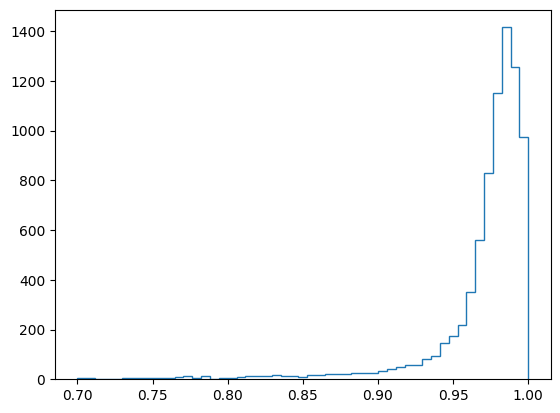

In [140]:
_ = plt.hist(ma[:, 150], bins=51, histtype='step', range=(0.7, 1), label='MA')

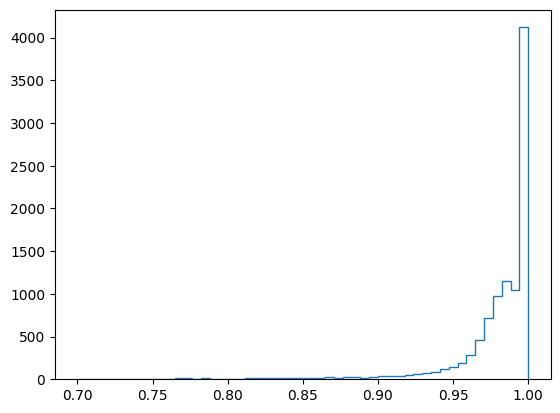

In [57]:
_ = plt.hist(ma_peak[:, 150], bins=51, histtype='step', range=(0.7, 1), label='MA peak')

### Predictions (with `ma`)

In [29]:
x = ma 
y = cvir[:, None]

In [30]:
model1 = MultiCAM_OG(n_features=165, n_targets=1)
model2 = MultiCAM(n_features=165, n_targets=1)

model1.fit(x, y)
model2.fit(x, y)

In [31]:
y_pred1 = model1.predict(x)
y_pred2 = model2.predict(x)

In [32]:
# significant correlation drop
spearmanr(y[:,0], y_pred1[:,0]), spearmanr(y, y_pred2[:,0])

(0.8032634746947371, 0.8033069077651853)

In [ ]:
# model1.predict(x[0, None, :]) # crashes with a single test point

In [33]:
model2.predict(x[0, None, :])[0,0], model2.predict(x)[0,0] # very different.

(7.24126672744751, 7.24126672744751)

**Takeaway**: Having no repeated values avoids both of the issues.

### Predictions (with `m_peak`)

Note that `ma_peak` has many more repeated values than `ma` especially for the late time features.

In [ ]:
x = ma_peak 
y = cvir[:, None]

In [21]:
model1 = MultiCAM_OG(n_features=165, n_targets=1)
model2 = MultiCAM(n_features=165, n_targets=1)

model1.fit(x, y)
model2.fit(x, y)

In [22]:
y_pred1 = model1.predict(x)
y_pred2 = model2.predict(x)

In [24]:
# significant correlation drop
spearmanr(y[:,0], y_pred1[:,0]), spearmanr(y, y_pred2[:,0])

(0.8063608693988956, 0.7518621048532789)

In [26]:
# model1.predict(x[0, None, :]) # crashes with a single test point

/var/folders/yl/5w7yl6bn1tsc5fjrdtsrsjhh0000gn/T/ipykernel_17859/3441362802.py:55: RuntimeWarning: invalid value encountered in divide
  xr = (xr - 1) * (len(self.x_train) - 1) / (len(x) - 1) + 1


ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [28]:
model2.predict(x[0, None, :])[0,0], model2.predict(x)[0,0] # very different.

(9.532846450805664, 8.377765655517578)

# Synthetic Dataset

In [147]:
# create synthetic dataset with repeated values in features.
np.random.seed(0)
n = 10000
n_features = 165
n_targets = 1
x = np.random.randn(n, n_features)
for ii, c in enumerate(np.linspace(-2, 2, n_features)):
    x[x[:,ii] > c, ii] = c

y = np.exp(np.arctan(x[:, ::5] + 1)).sum(axis=1)[:,None] + np.random.randn(n, n_targets) * 0.5 # only subset of features matter

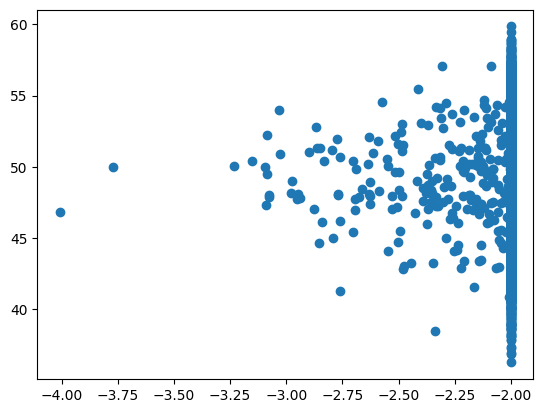

In [148]:
plt.plot(x[:,0], y[:,0], 'o')

# Prediction

In [138]:
model = MultiCAM(n_features, 1)
model.fit(x,y)

y_pred = model.predict(x)

In [139]:
model_og = MultiCAM_OG(n_features, 1)
model_og.fit(x,y)

y_pred_og = model_og.predict(x)

In [141]:
spearmanr(y[:,0], y_pred[:,0]), spearmanr(y[:,0], y_pred_og[:,0])

(0.9131484464796594, 0.9356251448582571)

In [144]:
idx = np.random.randint(0, len(x))
test_point = x[idx, None, :]
y1 = model.predict(test_point).item()
y2 = model.predict(x)[idx,0]
y1,y2

(45.95408648095023, 47.72086394738629)